### ***Theory of logistic regression***

Logistic regression is the baseline supervised ML algorithm for classification and has very close relationship with neural network: indeed, an artificial neural network can be viewed as a series of logistic regression classifiers stacked on top of each other.

##### ***Components***

Like Naive Bayes, logistic regression is a **probabilistic classifier** that uses these 3 components:
1.  a **classification function** that computes $y_{pred}$ (the estimated/predicted class), via $p(y|x)$. In general, the **sigmoid** is the chosen function for computing the probability of a sample to belong to a certain class:
$$
y_{pred} = sigmoid(z) = \frac{1}{1 + e^{-z}}
$$
$$
z = \alpha_0 + \sum_{i=1}^{n} \alpha_i X_i = \alpha_0 + \alpha_1X_1 + \alpha_2X_2 + ... + \alpha_n X_n
$$ 
*   $\alpha_0$:  bias term
*   $\alpha_i$:  i-th feature's weight
*   $X_i$:  i-th feature value
*   $n$:  number of features

2.  An **objective function** that we want to optimize for learning, usually involving minimizing a loss function corresponding to error on training examples. We will introduce the **cross-entropy loss** function:
$$ 
J_{x-entropy} = -\frac{1}{N} \sum_i^N y_i \log(y_{pred,i}) + (1 - y_i) \log(1 - y_{pred,i}) 
$$ 
*   $y_i$ is the true class of the sample
*   $N$: number of samples

3.  An algorithm for **optimizing** the objective function (*Stochastic Gradient Descent* and *RMSprop* algorithms)

#### ***Import libraries***

In [1]:
import sys
sys.path.append('../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import utils.model_evaluation as me
import pandas as pd

from utils.models.base_model import BaseModel
from utils.preprocessing import *
from utils.data_processer import *

#### ***Model definition***

In [3]:
class LogisticRegression(BaseModel):
    def __init__(self, num_features=None):
        """
        A class representing a logistic regression classifier configuration for specifying the number of features
        the classifier has to manage.

        :param num_features: The number of features of the dataset.
        :type num_features: Optional[int]
        """

        self.num_features = num_features

    def initialize_parameters(self, num_features):
        """
            Returns the parameters (weights and bias) for the logistic regression given the number of the dataset's features,
            initialized randomly.

            :param num_features: The number of features which represents also the number of weights to generate
            :type num_features: int
            :return: Parameters of the logistic regression classifier, specifically weights and biases.
        """

        self.num_features = num_features

        np.random.seed(0)  # For reproducibility

        # Parameters
        weights = np.random.randn(self.num_features, 1)
        bias = 0.

        return weights, bias

    def MSW(self, weights):
        """
        Computes the mean squared weights (MSW) of a logistic regression classifier's weights.

        This function calculates the average of the squared values of the weights present
        in the given parameters of a logistic regression classifier.

        :param weights: Weights of the logistic regression classifier
        :type weights: list
        :return: Mean of squared weights of the logistic regression classifier
        :rtype: float
        """

        # Calculate MSW
        partial_sum = 0.0
        n_weights = 0
        for W in weights:
            partial_sum = partial_sum + jnp.sum(W * W)
            n_weights = n_weights + W.size

        return partial_sum / n_weights

    # Loss function
    def cross_entropy(self):
        """
        Defines the cross-entropy loss function for classification problems with
        logistic output. This function calculates the negative log-likelihood
        of the predictions made by the model when compared with the true labels.
        It is commonly used as a loss function for binary classification tasks.

        :returns: A callable function that computes the cross-entropy loss
            for given input features, true labels, and model parameters. The
            callable expects four arguments: x (input features), y (true labels), 
            weights and bias (model parameters).
        :rtype: Callable
        """
        def callable(x, y, weights, bias):
            y_pred = self.predict(x, weights, bias)
            return -jnp.mean(y * jnp.log(y_pred) + (1 - y) * jnp.log(1 - y_pred))
        return callable

    def regularized_loss(self, loss_function, penalization):
        """
        Computes a regularized loss function by combining the given loss function with
        a penalization term. The penalization term is scaled based on the dataset size
        and involves the Mean Squared Weight (MSW) for the provided weights.

        This method returns a callable function that takes `x`, `y`, `weights` and `bias` as inputs
        and computes the regularized loss by applying the given loss function and adding
        the scaled penalization term.

        :param loss_function: A callable function representing the loss function to be
            applied to the dataset. It should accept `x`, `y`, `weights` and `bias` as inputs.
        :param penalization: A scalar value representing the penalization term to be
            applied during regularization. This value is combined with the MSW.
        :return: Returns a callable function which computes the regularized loss as a
            combination of the loss function and the penalization term.
        """
        def callable(x, y, weights, bias):
            return loss_function(x, y, weights, bias) + penalization / (2 * x.shape[0]) * self.MSW(weights)

        return callable

    # Optimisation algorithms
    def SGD(
            self,
            loss_function,
            epochs=1000,
            batch_size=128,
            learning_rate_min=1e-3,
            learning_rate_max=1e-1,
            learning_rate_decay=1000,
    ):
        """
        Creates a Stochastic Gradient Descent (SGD) optimizer as a callable function.

        This optimizer performs parameter updates based on gradient descent using
        a randomly selected batch of data at each iteration. The learning rate
        decays linearly over the specified number of epochs. The optimization
        process history, including the loss at each epoch, is also recorded and
        returned.

        :param loss_function: The loss function used to guide the optimization
            process. Should accept inputs, labels, and model parameters, and
            return a scalar loss value.
        :param epochs: The total number of iterations for training the model.
        :param batch_size: The number of samples to randomly select for computing
            gradients at each iteration.
        :param learning_rate_min: The minimum boundary for the learning rate.
        :param learning_rate_max: The initial maximum learning rate.
        :param learning_rate_decay: The rate at which the learning rate decreases
            linearly over the epochs. The learning rate reaches `learning_rate_min`
            when `epochs` are completed.
        :return: A callable optimizer function that applies SGD on the provided
            data and model parameters and returns the updated parameters and a
            history of loss values over all epochs.
        """
        def callable(x_train, y_train, weights, bias):
            # Number of samples
            num_samples = x_train.shape[0]

            # Loss and it's gradient functions
            loss = jax.jit(loss_function)
            grad_loss = jax.jit(jax.grad(loss_function, argnums=[2,3]))

            # History
            history = list()
            history.append(loss(x_train, y_train, weights, bias))

            for epoch in range(epochs):
                # Get learning rate
                learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))

                # Select batch_size indices randomly
                idxs = np.random.choice(num_samples, batch_size)

                # Calculate gradient
                grad_vals = grad_loss(x_train[idxs,:], y_train[idxs,:], weights, bias)

                # Update weights and bias
                weights = weights - learning_rate * grad_vals[0]
                bias = bias - learning_rate * grad_vals[1]

                # Update history
                history.append(loss(x_train, y_train, weights, bias))
            return weights, bias, history
        return callable

    def RMSprop(
            self,
            loss_function,
            epochs=1000,
            batch_size=128,
            learning_rate=0.1,
            decay_rate = 0.9,
            epsilon = 1e-8
    ):
        """
        Implements the RMSprop optimization algorithm. RMSprop is an adaptive learning rate method
        that maintains a moving average of the square of the gradients to normalize the gradient step sizes.
        This function returns a callable object capable of training a model using inputs, outputs, and
        initial parameters.

        :param loss_function: The loss function to be minimized. This function must take the training inputs,
            expected outputs, and model parameters as arguments and return the corresponding loss.
        :type loss_function: callable
        :param epochs: The number of training iterations.
        :type epochs: int, optional
        :param batch_size: The number of data samples to use in each iteration.
        :type batch_size: int, optional
        :param learning_rate: The initial learning rate for the optimizer.
        :type learning_rate: float, optional
        :param decay_rate: The decay rate used for the moving average of squared gradients.
        :type decay_rate: float, optional
        :param epsilon: A small constant to avoid division by zero.
        :type epsilon: float, optional
        :return: A callable that takes training inputs, training outputs, and model parameters as input and returns
            updated parameters and the training loss history.
        :rtype: callable
        """
        def callable(x_train, y_train, weights, bias):
            # Number of samples
            num_samples = x_train.shape[0]

            # Loss and it's gradient functions
            loss = jax.jit(loss_function)
            grad_loss = jax.jit(jax.grad(loss_function, argnums=[2,3]))

            # History
            history = list()
            history.append(loss(x_train, y_train, weights, bias))

            # Initialize cumulated square gradient
            cumulated_square_grad = list()
            cumulated_square_grad.append(np.zeros_like(weights))
            cumulated_square_grad.append(np.zeros_like(bias))

            for epoch in range(epochs):
                # Select batch_size indices randomly
                idxs = np.random.choice(num_samples, batch_size)

                # Calculate gradient
                grad_val = grad_loss(x_train[idxs,:], y_train[idxs,:], weights, bias)

                # Update cumulated square gradient of weights
                cumulated_square_grad[0] = decay_rate * cumulated_square_grad[0] + (1 - decay_rate) * grad_val[0] * grad_val[0]

                # Update weights
                weights = weights - learning_rate * grad_val[0] / (epsilon + np.sqrt(cumulated_square_grad[0]))

                # Update cumulated square gradient of bias
                cumulated_square_grad[1] = decay_rate * cumulated_square_grad[1] + (1 - decay_rate) * grad_val[1] * grad_val[1]

                # Update bias
                bias = bias - learning_rate * grad_val[1] / (epsilon + np.sqrt(cumulated_square_grad[1]))

                # Update history
                history.append(loss(x_train, y_train, weights, bias))
            return weights, bias, history
        return callable
        
    def fit(self, X=None, y=None, weights=None, bias=None, optimizer=None):
        """
        Fits the model to the data (X, y) using the specified parameters (weights and bias) and optimization
        strategy. The function applies the provided optimizer to train on the input data
        and returns the updated parameters and the loss function optimization history.

        The function does not modify the data or labels directly,
        but operates through the given optimizer.

        :param X: Input features for the model.
        :param y: Target labels corresponding to the input features.
        :param weights: Weights to optimize
        :param bias: Bias to optimize
        :param optimizer: Callable, the function used for optimization.
        :return: Optimized parameters and the loss function optimization history.
        """

        return optimizer(X, y, weights, bias)

    def predict(self, X=None, weights=None, bias=None):
        """
        Predicts output values based on the provided input data, model weights and bias.

        :param X: The input data, expected to be a NumPy array of shape (n_samples, n_features).
        :param weights: A list containing the weights of the model.
        :param bias: A float contain the bias of the model.
        :return: The predicted output values, as a NumPy array of shape (n_samples, n_outputs).
        """
        # Algorithm
        z = bias + X @ weights
        y_pred = jax.nn.sigmoid(-z)
        
        return y_pred

#### ***Read dataset***

In [4]:
dataset = pd.read_csv("../creditcard_2021.csv")
print(f"Number of samples: {len(dataset)}")
print(f"Number of fraudolent transaction: {(dataset['Class'] == 1).sum()}")
print(f"Ratio of fraudolent transaction: {dataset['Class'].mean()}")

Number of samples: 284807
Number of fraudolent transaction: 492
Ratio of fraudolent transaction: 0.001727485630620034


#### ***Usage of the model***

In [5]:
# Logistic Regression classifier
lr_classifier = LogisticRegression()

##### ***Example of usage (full features vector - v7)***

In [6]:
data = dataset[me.feature_vectors['v7'] + ['Class']]
data = data.to_numpy()

##### ***Split dataset into training and testing sets***

In [7]:
X_train, y_train, _, _, X_test, y_test = data_split(data_input=data, train_size=0.8)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 29), (227845, 1), (56962, 29), (56962, 1))

##### ***Apply SMOTE***
This helps to reduce the imbalance in the dataset between normal and fraudulent transactions

In [8]:
# Number of samples to generate
n_samples = 5000

# Minority class samples (attacks)
X_minority = X_train[y_train[:, 0] == 1]

# Generate synthetic fraudulent samples with SMOTE
X_smote = fit_resample(X_minority, n_samples, k=5)
y_smote = np.ones((n_samples, 1))

# Add synthetic data to the training set
X_train = np.concatenate((X_train, X_smote), axis=0)
y_train = np.concatenate((y_train, y_smote), axis=0)

##### ***Normalize training and testing sets, with min-max scaling method***

In [9]:
# Normalize training set
X_train_normalized, data_train_min, data_train_max = min_max(data=X_train)

# Normalize testing set
X_test_normalized, _, _ = min_max(X_test, data_train_min, data_train_max)

##### ***Train Logistic Regression Classifier***

In [10]:
# Initialize weights and biases
weights, bias = lr_classifier.initialize_parameters(X_train_normalized.shape[1])

# Train logistic regression classifier
updated_weights, updated_bias, history = lr_classifier.fit(
    X = X_train_normalized,
    y = y_train,
    weights = weights,
    bias = bias,
    optimizer = lr_classifier.RMSprop(
        loss_function=lr_classifier.regularized_loss(
            lr_classifier.cross_entropy(),
            penalization=0.5
        ),
        epochs=8000,
        batch_size=4096,
        learning_rate=0.001,
        decay_rate=0.9,
        epsilon=1e-8,
    )
)

##### ***Evaluation***

In [11]:
# Get testing predicted labels
y_pred = lr_classifier.predict(X_test_normalized, updated_weights, updated_bias)
y_fraud_pred = y_pred >= 0.5

Precision: 0.9078947368421053
Recall: 0.6831683168316832
F1 Score: 0.7796610169491525
Accuracy: 0.9993153330290369
AUC Score: 0.8415226048026446


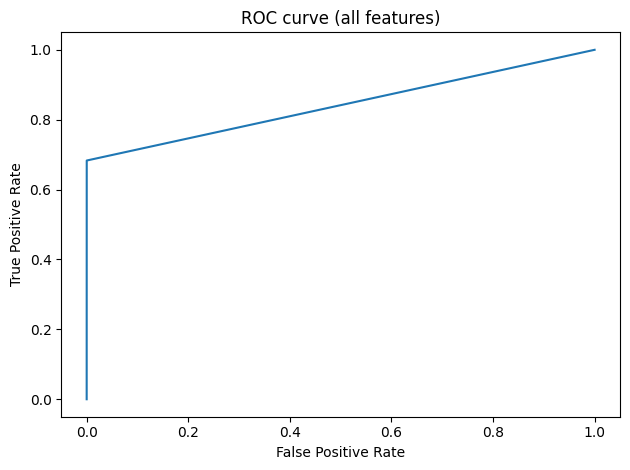

In [12]:
metrics = me.compute_metrics(
    y_true=y_test,
    y_pred=y_fraud_pred,
    metrics_df=None,
    dataset_label='v7 training'
)

print("Precision:", metrics["precision"][0])
print("Recall:", metrics["recall"][0])
print("F1 Score:", metrics["f1-score"][0])
print("Accuracy:", metrics["accuracy"][0])

fpr, tpr, auc = me.compute_roc_auc(y_test, y_fraud_pred)
print("AUC Score:", auc)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (all features)")
plt.tight_layout()
plt.show()

#### ***Training and Evaluation (for all feature vectors)***


In [13]:
# Split data
X_train, y_train, _, _, X_test, y_test = data_split(dataset.to_numpy(), train_size=0.8)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((227845, 30), (227845, 1), (56962, 30), (56962, 1))

In [14]:
# Number of samples to generate
n_samples = 5000

# Minority class samples (attacks)
X_minority = X_train[y_train[:, 0] == 1]

# Generate synthetic fraudulent samples with SMOTE
X_smote = fit_resample(X_minority, n_samples, k=5)
y_smote = np.ones((n_samples, 1))

# Add synthetic data to the training set
X_train = np.concatenate((X_train, X_smote), axis=0)
y_train = np.concatenate((y_train, y_smote), axis=0)

In [15]:
# Normalize training set
X_train_normalized, data_train_min, data_train_max = min_max(X_train)

# Normalize testing set
X_test_normalized, _, _ = min_max(X_test, data_train_min, data_train_max)

In [16]:
# Metrics
metrics_training = pd.DataFrame()
metrics_testing = pd.DataFrame()

# ROC AUC scores
roc_auc_training = {}
roc_auc_testing = {}

# Run the model for each feature vector
for key, value in me.feature_vectors.items():
    print(f"Running model for feature vector {key}...")

    # Get dataset for the current feature vector
    X_train_curr = X_train_normalized[:, np.array(me.feature_masks[key]).astype(bool)]
    X_test_curr = X_test_normalized[:, np.array(me.feature_masks[key]).astype(bool)]

    # Initialize weights and biases
    weights, bias = lr_classifier.initialize_parameters(X_train_curr.shape[1])

    # Train Logistic Regression Classifier

    if key == 'v6' or key == 'v7':
        updated_weights, updated_bias, history = lr_classifier.fit(
            X=X_train_curr,
            y=y_train,
            weights=weights,
            bias=bias,
            optimizer=lr_classifier.RMSprop(
                loss_function=lr_classifier.regularized_loss(
                    lr_classifier.cross_entropy(),
                    penalization=0.5
                ),
                epochs=7500,
                batch_size=4096,
                learning_rate=0.001,
                decay_rate=0.9,
                epsilon=1e-8,
            )
        )
    else:
        updated_weights, updated_bias, history = lr_classifier.fit(
            X=X_train_curr,
            y=y_train,
            weights=weights,
            bias=bias,
            optimizer=lr_classifier.RMSprop(
                loss_function=lr_classifier.regularized_loss(
                    lr_classifier.cross_entropy(),
                    penalization=0.5
                ),
                epochs=10000,
                batch_size=10000,
                learning_rate=0.001,
                decay_rate=0.9,
                epsilon=1e-8,
            )
        )

    # Get training predicted labels
    y_train_pred = lr_classifier.predict(X_train_curr, updated_weights, updated_bias)
    train_fraud_pred = y_train_pred >= 0.5

    # Save training metrics
    metrics_training = me.compute_metrics(
        y_true=y_train,
        y_pred=train_fraud_pred,
        metrics_df=metrics_training,
        dataset_label=key + ' training'
    )
    roc_auc_training[key] = me.compute_roc_auc(y_train, y_train_pred)

    # Get validation predicted labels
    # ...

    # Get testing predicted labels
    y_test_pred = lr_classifier.predict(X_test_curr, updated_weights, updated_bias)
    test_fraud_pred = y_test_pred >= 0.5

    # Save testing metrics
    metrics_testing = me.compute_metrics(
        y_true=y_test,
        y_pred=test_fraud_pred,
        metrics_df=metrics_testing,
        dataset_label=key + ' testing'
    )
    roc_auc_testing[key] = me.compute_roc_auc(y_test, y_test_pred)

Running model for feature vector v1...
Running model for feature vector v2...
Running model for feature vector v3...
Running model for feature vector v4...
Running model for feature vector v5...
Running model for feature vector v6...
Running model for feature vector v7...


In [17]:
metrics_training

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1 training,3507,227407,47,1884,0.991707,0.650529,0.986775,0.784125,232845,[5391.0]
1,v2 training,2001,227420,34,3390,0.985295,0.371174,0.983292,0.538917,232845,[5391.0]
2,v3 training,3422,227407,47,1969,0.991342,0.634762,0.986451,0.772460,232845,[5391.0]
3,v4 training,1930,227419,35,3461,0.984986,0.358004,0.982188,0.524742,232845,[5391.0]
4,v5 training,3636,227403,51,1755,0.992244,0.674457,0.986168,0.801058,232845,[5391.0]
5,v6 training,3852,227410,44,1539,0.993201,0.714524,0.988706,0.829547,232845,[5391.0]
6,v7 training,3870,227409,45,1521,0.993274,0.717863,0.988506,0.831721,232845,[5391.0]


In [18]:
metrics_testing

,set of features,tp,tn,fp,fn,accuracy,recall,precision,f1-score,total transaction,fraud transactions
0,v1 testing,57,56851,10,44,0.999052,0.564356,0.850746,0.678571,56962,[101.0]
1,v2 testing,36,56856,5,65,0.998771,0.356436,0.878049,0.507042,56962,[101.0]
2,v3 testing,55,56852,9,46,0.999034,0.544554,0.859375,0.666667,56962,[101.0]
3,v4 testing,31,56856,5,70,0.998683,0.306931,0.861111,0.452555,56962,[101.0]
4,v5 testing,64,56852,9,37,0.999192,0.633663,0.876712,0.735632,56962,[101.0]
5,v6 testing,69,56853,8,32,0.999298,0.683168,0.896104,0.775281,56962,[101.0]
6,v7 testing,68,56854,7,33,0.999298,0.673267,0.906667,0.772727,56962,[101.0]


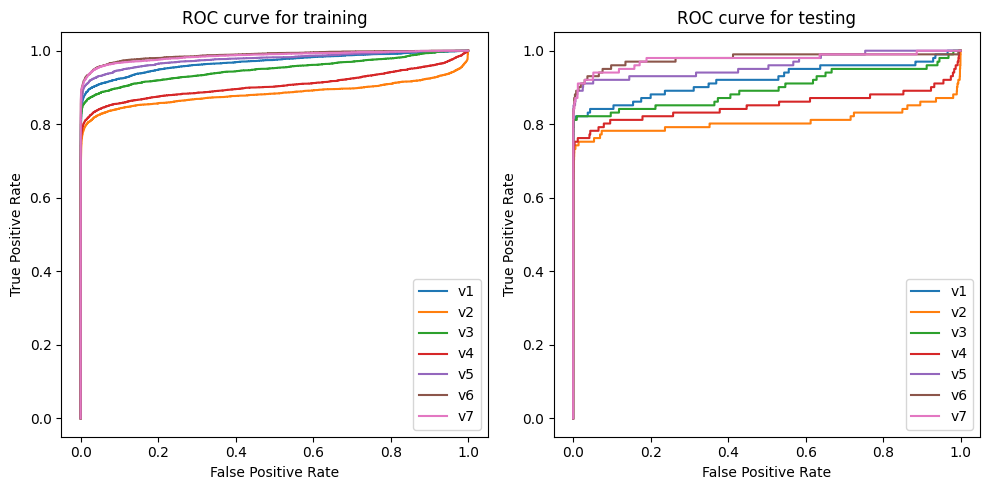

Training AUC:
v1 -> 0.97
v2 -> 0.88
v3 -> 0.95
v4 -> 0.91
v5 -> 0.98
v6 -> 0.99
v7 -> 0.99

Testing AUC:
v1 -> 0.92
v2 -> 0.81
v3 -> 0.90
v4 -> 0.85
v5 -> 0.96
v6 -> 0.98
v7 -> 0.98


In [19]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

#ROC curve for training
for i in roc_auc_training.keys():
    axs[0].plot(roc_auc_training[i][0], roc_auc_training[i][1], label = i)
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC curve for training")
    axs[0].legend()

#ROC curve for testing
for i in roc_auc_testing.keys():
    axs[1].plot(roc_auc_testing[i][0], roc_auc_testing[i][1], label = i)
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_title("ROC curve for testing")
    axs[1].legend()

plt.tight_layout()
plt.show()

print("Training AUC:")
for i, auc in roc_auc_training.items():
    print(f"{i} -> {auc[2]:.2f}")

print("\nTesting AUC:")
for i, auc in roc_auc_testing.items():
    print(f"{i} -> {auc[2]:.2f}")